<a href="https://colab.research.google.com/github/0xflame-7/Movie-Recommendation/blob/main/Collaborative_Filtering_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
device

device(type='cpu')

In [44]:
df = pd.read_csv("/content/drive/MyDrive/Movie-Recommentation-data/ml-latest-small/ratings.csv")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [46]:
df.userId.nunique()

610

In [47]:
df.movieId.nunique()

9724

In [48]:
df.rating.value_counts()

,count
rating,
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791


In [49]:
df.shape

(100836, 4)

Training Dataset Class Wrapper

In [50]:
class MovieDataset:
  def __init__(self, users, movies, ratings):
    self.users = users
    self.movies = movies
    self.ratings = ratings
  def __len__(self):
    return len(self.users)

  def __getitem__(self, idx):
    user = self.users[idx]
    movie = self.movies[idx]
    rating = self.ratings[idx]

    return {
        "users": torch.tensor(user, dtype=torch.long),
        "movies": torch.tensor(movie, dtype=torch.long),
        "ratings": torch.tensor(rating, dtype=torch.long)
    }

Create the model

In [51]:
class RecSysModel(nn.Module):
  def __init__(self, n_users, n_movies):
    super().__init__()

    self.user_embedding = nn.Embedding(n_users, 32)
    self.movie_embedding = nn.Embedding(n_movies, 32)

    self.out = nn.Linear(64, 1)

  def forward(self, users, movies, ratings=None):
    user_embedding = self.user_embedding(users)
    movie_embedding = self.movie_embedding(movies)

    output = torch.cat([user_embedding, movie_embedding], dim=1)
    output = self.out(output)

    return output

In [52]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)

In [53]:
train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=4, shuffle=True, num_workers=2)

dataiter = iter(train_loader)
dataloader_data = dataiter.__next__()

print(dataloader_data)

{'users': tensor([124, 465, 604, 289]), 'movies': tensor([7335, 4403, 1479,  888]), 'ratings': tensor([3, 3, 3, 4])}


In [54]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [55]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


Manually run a forward path

In [56]:
print(dataloader_data['users'])
print(dataloader_data['users'].size())

print(dataloader_data['movies'])
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)

tensor([124, 465, 604, 289])
torch.Size([4])
tensor([7335, 4403, 1479,  888])
torch.Size([4])


In [57]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])

print(f"Size of User embed: {user_embeds.size()}")
print(f"Size of Movie embed: {movie_embeds.size()}")

Size of User embed: torch.Size([4, 32])
Size of Movie embed: torch.Size([4, 32])


In [58]:
output = torch.cat([user_embeds, movie_embeds], dim=1)
print(output.size())
print(output)

output = out(output)
print(output.size())
print(output)

torch.Size([4, 64])
tensor([[ 0.8219, -0.3753, -1.1096,  0.9415, -0.4915, -0.0394,  1.3618,  2.6469,
          0.9568,  0.1311, -0.3644,  0.2855,  2.1285,  0.9604,  0.6754,  0.1273,
         -0.7193, -0.6031,  1.3813, -0.0392, -0.2458, -0.8409, -0.9510,  0.5988,
         -3.0511, -0.0827,  0.4672,  0.0718,  2.0097, -1.2033, -0.1590, -3.8083,
         -1.4933, -1.0864,  0.9916,  2.1113, -0.4511, -0.0346, -0.5900,  0.2350,
          1.4568, -0.0953, -0.4431, -0.0443,  0.4007,  0.4386,  0.2536,  0.8647,
         -0.0559, -0.4544,  0.0239,  0.3863,  0.2893, -1.3321,  1.2043,  1.9209,
          0.4432, -0.5449, -0.6358, -0.8184,  1.2987,  0.8285,  1.1014, -0.6031],
        [-0.4010, -0.4368,  0.1901,  0.7589,  1.6725,  1.1061, -1.5927,  0.6533,
         -1.1169, -0.6126,  0.3009, -2.6204,  0.2999,  1.0625, -0.2888, -1.1355,
          0.6203,  1.3545, -0.4263,  0.7249,  0.6072, -0.0476,  0.8669,  2.2336,
          2.6933, -0.8082, -0.5973,  0.6826,  1.1692,  1.7309, -1.1822,  1.6331,
       

In [60]:
with torch.no_grad():
  model_output = model(dataloader_data['users'], dataloader_data['movies'])
  print(f"Model output: {model_output}, Size: {model_output.size()}")

Model output: tensor([[ 0.4051],
        [ 0.1409],
        [ 0.4419],
        [-0.3988]]), Size: torch.Size([4, 1])


In [62]:
rating = dataloader_data['ratings']
print(rating)
print(rating.view(4, -1))

print(model_output)

print(rating.sum())
print(model_output.sum() - rating.sum())

tensor([3, 3, 3, 4])
tensor([[3],
        [3],
        [3],
        [4]])
tensor([[ 0.4051],
        [ 0.1409],
        [ 0.4419],
        [-0.3988]])
tensor(13)
tensor(-12.4109)


Run the Training Loop

In [66]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
for epoch_i in range(epochs):
  for i, train_data in enumerate(train_loader):
    output = model(
        train_data['users'],
        train_data['movies']
    )

    rating = train_data['ratings'].view(4, -1).to(torch.float32)

    loss = loss_func(output, rating)
    total_loss += loss.sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    step_cnt = step_cnt + len(train_data['users'])

    if step_cnt % plot_steps == 0:
      avg_loss = total_loss /(len(train_data['users']) * plot_steps)
      print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
      all_losses_list.append(total_loss)
      total_loss = 0


epoch 0 loss at step: 5000 is 0.49974626428708435
epoch 0 loss at step: 10000 is 0.19403043022863567
epoch 0 loss at step: 15000 is 0.11505440751590068
epoch 0 loss at step: 20000 is 0.08631794081758708
epoch 0 loss at step: 25000 is 0.07437966625941918
epoch 0 loss at step: 30000 is 0.06753231100281701
epoch 0 loss at step: 35000 is 0.06385369915044867
epoch 0 loss at step: 40000 is 0.06466514127689879
epoch 0 loss at step: 45000 is 0.062220190101955085
epoch 0 loss at step: 50000 is 0.059245248198043554
epoch 0 loss at step: 55000 is 0.05988205827483907
epoch 0 loss at step: 60000 is 0.05733725309129804
epoch 0 loss at step: 65000 is 0.059859298788616434
epoch 0 loss at step: 70000 is 0.05903522237790748
epoch 0 loss at step: 75000 is 0.059513073888607326
epoch 0 loss at step: 80000 is 0.057487603911943734
epoch 0 loss at step: 85000 is 0.0577913528312929
epoch 0 loss at step: 90000 is 0.05573632221966982


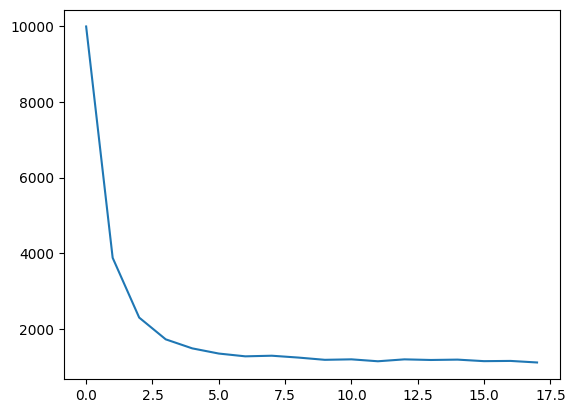

In [67]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

Evaluation with RMSE

In [71]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()
with torch.no_grad():
  for i, batched_data in enumerate(valid_loader):
    model_ouput = model(batched_data['users'], batched_data['movies'])
    model_output_list.append(model_output.sum().item() / len(batched_data['users']))
    target_rating = batched_data['ratings']

    target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))
    # print(f"model_output: {model_output}, target_rating: {target_rating}")

mse = mean_squared_error(target_rating_list, model_output_list)
rms = np.sqrt(mse)

print(f"RMSE: {rms}")

RMSE: 0.5557895994200184


Recal@k

In [73]:
from collections import defaultdict

user_est_true = defaultdict(list)

with torch.no_grad():
  for i, batched_data in enumerate(valid_loader):
    users = batched_data['users']
    movies = batched_data['movies']
    ratings = batched_data['ratings']
    model_output = model(batched_data['users'], batched_data['movies'])

    for i in range(len(users)):
      user_id = users[i].item()
      movie_id = movies[i].item()
      rating = ratings[i].item()

      print(f"User: {user_id}, Movie: {movie_id}, Rating: {rating}, Model Output: {model_output[i][0].item()}")
      user_est_true[user_id].append((model_output[i][0].item(), rating))

Streaming output truncated to the last 5000 lines.
User: 401, Movie: 333, Rating: 4, Model Output: 3.517838478088379
User: 532, Movie: 901, Rating: 4, Model Output: 4.379857063293457
User: 76, Movie: 6693, Rating: 5, Model Output: 4.155109405517578
User: 589, Movie: 224, Rating: 5, Model Output: 3.570256233215332
User: 262, Movie: 4791, Rating: 4, Model Output: 4.17996883392334
User: 176, Movie: 6614, Rating: 2, Model Output: 2.7925853729248047
User: 491, Movie: 811, Rating: 4, Model Output: 3.8625545501708984
User: 306, Movie: 5369, Rating: 4, Model Output: 2.4240880012512207
User: 567, Movie: 418, Rating: 3, Model Output: 3.9879562854766846
User: 598, Movie: 2019, Rating: 4, Model Output: 2.846294403076172
User: 609, Movie: 1180, Rating: 3, Model Output: 3.4912915229797363
User: 327, Movie: 771, Rating: 2, Model Output: 2.911212682723999
User: 589, Movie: 6429, Rating: 3, Model Output: 3.3061633110046387
User: 609, Movie: 2466, Rating: 3, Model Output: 3.007455825805664
User: 327, Mo

In [75]:
with torch.no_grad():
  precisions = dict()
  recalls = dict()

  k = 100
  threshold = 3.5

  for uid, user_ratings in user_est_true.items():
    user_ratings.sort(key=lambda x: x[0], reverse=True)

    n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

    n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

    n_rel_and_rec_k = sum(
        ((true_r >= threshold) and (est >= threshold))
        for (est, true_r) in user_ratings[:k]
    )

    print(f"User: {uid}, n_rel: {n_rel}, n_rec_k: {n_rec_k}, n_rel_and_rec_k: {n_rel_and_rec_k}")

    precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
    recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0


User: 283, n_rel: 4, n_rec_k: 7, n_rel_and_rec_k: 3
User: 545, n_rel: 7, n_rec_k: 0, n_rel_and_rec_k: 0
User: 482, n_rel: 49, n_rec_k: 40, n_rel_and_rec_k: 27
User: 447, n_rel: 56, n_rec_k: 0, n_rel_and_rec_k: 0
User: 473, n_rel: 74, n_rec_k: 6, n_rel_and_rec_k: 5
User: 459, n_rel: 7, n_rec_k: 8, n_rel_and_rec_k: 7
User: 364, n_rel: 4, n_rec_k: 0, n_rel_and_rec_k: 0
User: 381, n_rel: 10, n_rec_k: 11, n_rel_and_rec_k: 7
User: 211, n_rel: 12, n_rec_k: 5, n_rel_and_rec_k: 1
User: 325, n_rel: 16, n_rec_k: 13, n_rel_and_rec_k: 11
User: 386, n_rel: 31, n_rec_k: 8, n_rel_and_rec_k: 6
User: 513, n_rel: 22, n_rec_k: 3, n_rel_and_rec_k: 3
User: 598, n_rel: 22, n_rec_k: 0, n_rel_and_rec_k: 0
User: 599, n_rel: 18, n_rec_k: 0, n_rel_and_rec_k: 0
User: 226, n_rel: 9, n_rec_k: 13, n_rel_and_rec_k: 9
User: 49, n_rel: 5, n_rec_k: 0, n_rel_and_rec_k: 0
User: 9, n_rel: 2, n_rec_k: 0, n_rel_and_rec_k: 0
User: 443, n_rel: 2, n_rec_k: 0, n_rel_and_rec_k: 0
User: 566, n_rel: 2, n_rec_k: 0, n_rel_and_rec_k: 0

In [77]:
print(f"Precision: {sum(prec for prec in precisions.values()) / len(precisions)}")
print(f"Recall: {sum(rec for rec in recalls.values()) / len(recalls)}")

Precision: 0.5667884183739282
Recall: 0.5552384736618402
